---
# Project: Diabetes OLS Analysis using StatsModel

_A special thank you to Mark Wicks for the motivations for the following notebooks._

### Digging Deeper 
This notebook will look at the same diabetes dataset from sklearn, but it will instead be using StatsModels. The StatsModels has a wealth of statistical information that sklearn does not have. I will be using StatsModels Ordinary Least Square (OLS) Linear Regression model since sklearn `LinearRegression()` is pretty much a OLS.

__Part 1__ of this notebook will dive into the wealth of information that StatsModels presents, and use that to interrogate the validity of the OLS model as well as the features chosen. __Part 2__ will use the information in Part 1 to do an iteration of which features used to train the OLS model, and comment on other options to try for optimization. Lastly, __Part 3__ will mimic the OLS sklearn notebook, to show how to access the same information.

Throughout the notebook, there will be checks to compare the calculations from StatsModels with sklearn. 

---
### Part 0: Setup
Getting the notebook ready, loading the data, and a quick verification everything loaded correctly. For more information on the dataset, see steps 1-4 in the `Diabetes OLS Analysis - sklearn.ipynb` notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.datasets import load_diabetes
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import OLSInfluence as influence
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Import dataframes
df = pd.read_csv('Data/df.csv', index_col=0)
df_res = pd.read_csv('Data/df_res.csv', index_col=0)

# Import 
X_train = pd.read_csv('Data/X_train.csv', index_col=0)
X_test = pd.read_csv('Data/X_test.csv', index_col=0)
Y_train = pd.read_csv('Data/Y_train.csv', index_col=0)
Y_test = pd.read_csv('Data/Y_test.csv', index_col=0)

In [2]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [3]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
315,0.009016,-0.044642,-0.020218,-0.053871,0.031454,0.020607,0.056003,-0.039493,-0.010904,-0.001078
71,-0.001882,-0.044642,0.033673,0.125158,0.024574,0.026243,-0.010266,-0.002592,0.026714,0.061054
23,0.045341,0.050680,0.060618,0.031053,0.028702,-0.047347,-0.054446,0.071210,0.133599,0.135612
10,-0.096328,-0.044642,-0.083808,0.008101,-0.103389,-0.090561,-0.013948,-0.076395,-0.062913,-0.034215
336,-0.020045,-0.044642,0.085408,-0.036656,0.091996,0.089499,-0.061809,0.145012,0.080948,0.052770


In [4]:
Y_train.head()

,target
315,97.0
71,270.0
23,245.0
10,101.0
336,306.0


![separator2](https://user-images.githubusercontent.com/7065401/39119518-59fa51ce-46ec-11e8-8503-5f8136558f2b.png)

### Part 1: StatsModel OLS
This sections will go into some of the statistical information the StatsModel gives access to, but will not be a comprehensive breakdown.

Since the dataset has already been train_test_split in the `Diabetes OLS Analysis - sklearn.ipynb` notebook (Step 5), the same training dataset will be used so the results can be compared. To train the StatsModel, need to use `sm.OLS(y, X)`, but a __key__ difference is that the sm does not assume a intercept. So that needs to be added to the dataset before training the model.

<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">1.</span>
            Adding a y-intercept constant to the training data (<code>X_train_sm</code>) and then training the model on <code>X_train_sm</code>.
        </td>
    </tr>
</table>

In [5]:
# The y-intercept is not default in StatsModels. To do add this to
# the model, we will add a constant column to our X data. 
X_train_sm = X_train.copy()
X_train_sm = sm.add_constant(X_train_sm)

# change the name of const column to y-int
X_train_sm.rename(columns={'const': 'y-int'}, inplace=True)
X_train_sm.head()

,y-int,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
315,1.0,0.009016,-0.044642,-0.020218,-0.053871,0.031454,0.020607,0.056003,-0.039493,-0.010904,-0.001078
71,1.0,-0.001882,-0.044642,0.033673,0.125158,0.024574,0.026243,-0.010266,-0.002592,0.026714,0.061054
23,1.0,0.045341,0.050680,0.060618,0.031053,0.028702,-0.047347,-0.054446,0.071210,0.133599,0.135612
10,1.0,-0.096328,-0.044642,-0.083808,0.008101,-0.103389,-0.090561,-0.013948,-0.076395,-0.062913,-0.034215
336,1.0,-0.020045,-0.044642,0.085408,-0.036656,0.091996,0.089499,-0.061809,0.145012,0.080948,0.052770


In [6]:
# Now we can train the model.
lr_sm = sm.OLS(Y_train, X_train_sm)
res_sm = lr_sm.fit()

In [7]:
# A quick comparing of the coef and y-int from sklearn and sm.
# Results should be identical because it is the same data/model. 
_df_res_sm = pd.DataFrame(res_sm.params, columns=['sm'])
df_res['sm'] = _df_res_sm
df_res.round(3)

,sklearn,sm,sm_pv
y-int,151.531,151.531,151.231
age,-59.678,-59.678,NaN
sex,-303.298,-303.298,-225.089
bmi,558.369,558.369,628.376
bp,319.486,319.486,281.883
s1,-783.279,-783.279,NaN
s2,316.650,316.650,NaN
s3,222.998,222.998,NaN
s4,352.210,352.210,NaN
s5,770.213,770.213,569.592


<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">2.</span>
            StatsModels Linear Regression Summary to understand more about the statistical inferences of the data.
        </td>
    </tr>
</table>

The point of using StatsModels is to get more statistical inferences from the data. A powerful thing sm has is the summary, which gives a lot of really powerful information. Most of which are not accessible with sklearn. 

In [8]:
print(res_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     34.80
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           1.61e-44
Time:                        18:58:45   Log-Likelihood:                -1664.3
No. Observations:                 309   AIC:                             3351.
Df Residuals:                     298   BIC:                             3392.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y-int        151.5312      3.069     49.378      0.0

<br>

_Below are a few highlight about this dataset's OLS model._

##### First Table - general info
* `Adj. R-squared:` (≤ R^2) takes into account the number of independent variable in the regression model. There is a penalty for more parameters which can the lower this number compared to R^2. _This is better to use when comparing models._
* `Prob (F-statistic):` probability of null hypothesis to be true. _For this model there is a 1 in 10^44 likelihood all the coefficients are zero._
* `Log-Likelihood`, `AIC`, & `BIC`: used different criteria to compare models. _The model with the lowest value is preferred._

##### Second Table - all about the variables 
* `std err`: The standard error calculated for that coef. As is the case with comparing std deviation, the relative magnitude of the coef to error matters. _For `age`, `s2`, `s3`, & `s6` the error is larger than the coef. `s1` and `s4` have errors ~ half the magnitude of the coef. This also lines up with the p-values._ 
* `P>|t|`: This is your p-value for each coef! significant values are lower than 0.05/0.01, verse higher which are not. _`y-int`, `sex`, `bmi`, `bp`, and `s5` are the only features with significant p-values. This suggests the other features are not adding a lot of value to the model._

##### Third Table - normal-niss of your data
* `Prob(Omnibus):` _Small probability indicates normal._
* `Skew:` Should be about 0. > 0 is left skewed (long tail on the right), < 0 is right skewed (long tail on the left). _The training dataset, it is sightly right-skewed._
* `Kurtosis:` Is the sharpness of the distribution. A normal distribution = 3. > 3 is a smaller FWHM, a < 3 is a larger FWHM. _This dataset is sharper than a normal distribution._
* `Prob(JB):` < 0.05, Normal distribution. > 0.05, Not a normal distribution. _This suggests the dataset is not very normalized_
* `Cond. No.:` Condition number is a measurement of how sensitive a function is to changes/errors in input. It also gives insight to collinearity/multicollinearity. Smaller is better. _Used to compare models. But suggest there is might be some linear dependence between predicted values._ 

#### Summary Takeaways
Not only is the summary give us statistical information of the data and the fit of the model. It can also be used to help determine if the assumption for linearly is valid. [This article](https://towardsdatascience.com/how-do-you-check-the-quality-of-your-regression-model-in-python-fa61759ff685) has a good overall summary. 
* Features: A different model using only the statistically significant features, could simplify the model without much cost to the accuracy. This will also help fight against over/underfitting the data. (`y-int`, `sex`, `bmi`, `bp`, `s5`). See Part 2 for this model.
* Normality: The dataset is not perfectly normalize (skewed right, sharper, JB is also quite high, which is concerning). <br>

The next part of this section will continue to look at the validity of the model. 

---
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">3.</span>
            Add y-int to `X_test` and predict new values of the traget, y, with `X_test_sm`.
        </td>
    </tr>
</table>

In [9]:
# Adding y-intercept to X_test data. 
X_test_sm = X_test.copy()
X_test_sm = sm.add_constant(X_test_sm)

# change the name of const column to y-int
X_test_sm.rename(columns={'const': 'y-int'}, inplace=True)
X_test_sm.head()

,y-int,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
140,1.0,0.041708,0.050680,0.014272,0.042530,-0.030464,-0.001314,-0.043401,-0.002592,-0.033249,0.015491
217,1.0,0.074401,-0.044642,0.031517,0.101058,0.046589,0.036890,0.015505,-0.002592,0.033657,0.044485
439,1.0,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
311,1.0,0.096197,-0.044642,0.040140,-0.057314,0.045213,0.060690,-0.021311,0.036154,0.012553,0.023775
321,1.0,0.096197,-0.044642,0.051996,0.079254,0.054845,0.036577,-0.076536,0.141322,0.098646,0.061054


In [10]:
Y_pred_sm = res_sm.predict(X_test_sm)
Y_pred_sm.head()

140    143.401343
217    216.836423
439    110.523776
311    166.308534
321    294.649319
dtype: float64

In [11]:
# Same as sklearn

---
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">4.</span>
            Looking for independence of variables with residual plots and variance influence factors.
        </td>
    </tr>
</table>

#### Regression Plots from StatsModels
StatsModels has a nice and quick graphics for plotting the feature residuals for a given feature. 

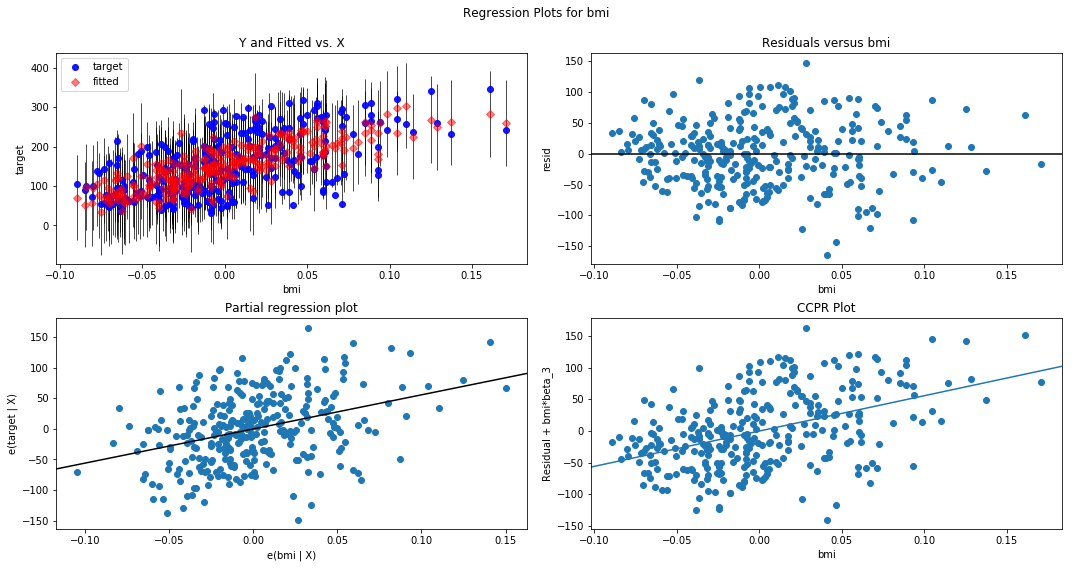

In [12]:
fig_res_bmi = sm.graphics.plot_regress_exog(res_sm, 'bmi', fig=plt.figure(figsize=(15,8)))

There are four graphs that it will out put:
1. `Y and Fitted vs X`: This is a plot of the dependent variable on the y-axis versus a given independent variable on the x-axis. Plotted is the predicted valued (fitted, red) with the confidence interval (wiskers, black) and the actual value (target, blue). The slope will show if the independent variable it positively, negatively, or nuetrally correlated. 
2. `Residuals versus <indepd variable>`: The assumption that each feature is indipendent (assuption of a LR fit) is validated when there is a random distrubution about y=0. If there is clustering will show a breakdown in this assumption. 
3. `Partial regression plot`: When there are more then one independent variables, this residual plot attempts to take that into account. 
4. `Component and Component-Plus-Residual (CCPR)`: Is a specific type of partial _residual_ plot which showes also attempts to take into account the residual's effect with other variables in the model.

To get plots for each feature, use the following code:
```
for c in load_diabetes().feature_names:
    fig_res = sm.graphics.plot_regress_exog(res_sm, c, fig=plt.figure(figsize=(15,8)))
    fig_res.show
```

#### Residual vs feature plots

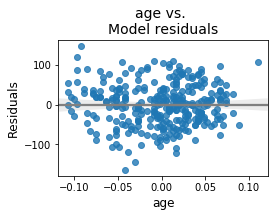

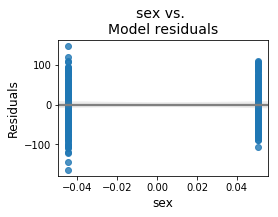

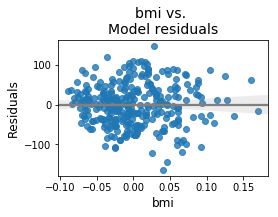

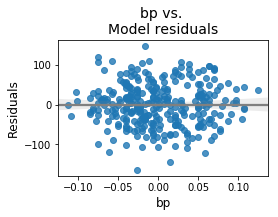

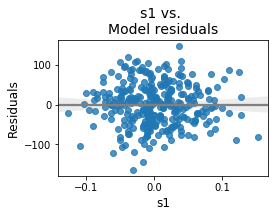

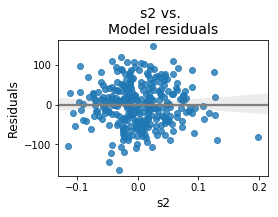

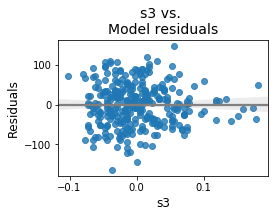

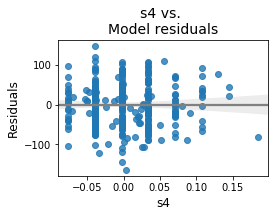

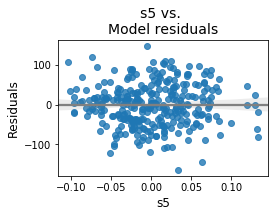

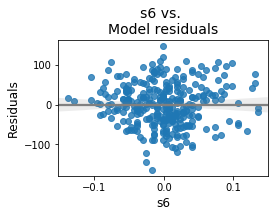

In [13]:
for feature in load_diabetes().feature_names:
    plt.figure(figsize=(3.75,2.5))
    sns.regplot(x=X_train_sm[feature], y=res_sm.resid, line_kws = {'color':'grey'})
    plt.title("{} vs. \nModel residuals".format(feature), fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.show()

#### Variance influence factors (VIF)
This quantifies how much multicollinearity a feature has for the OLS. VIF greater than 5 or 10 indicates a feature which is highly collinear with other variables. Recall, non-collinearity is one of the assumptions of linear regression.

In [14]:
df_vif = pd.DataFrame(index=X_train_sm.columns)
df_vif["VIF Factor"] = [vif(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
round(df_vif, 1)

,VIF Factor
y-int,1.0
age,1.3
sex,1.3
bmi,1.6
bp,1.5
s1,53.6
s2,36.6
s3,14.5
s4,8.9
s5,9.8


#### Variable Independence Takeaways (non-collinearity)
* Clustering: `sex` is clustered into two groups and `s4` is also clustered into ~7 bin values with some values between. 
* Most of the features are randomness about x=0 as well as y=0, with some tail values with x > 0.
* From VIF analysis: `s1`, `s2`, `s3` indicate highly multicollinearity. `s4`, `s5` have a mid-range multicollinearity value.

---
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">5.</span>
            Looking at the residual of the fitted target values.
        </td>
    </tr>
</table>

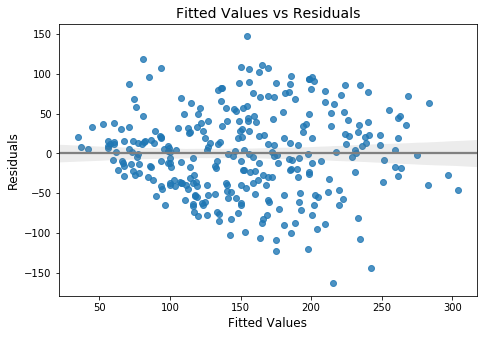

In [15]:
# This plot checks if the dataset is homoscedastic
# (an assumption of LR). 
plt.figure(figsize=(7.5,5))
sns.regplot(x=res_sm.fittedvalues, y=res_sm.resid, line_kws={'color':'grey'})
plt.title("Fitted Values vs Residuals", fontsize=14)
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.show()

#### Fitted Residual Takeaways
* There is increase the residual value as fitted values increase, which is more of the case for residuals < 0.
* There for this data is hetroscedastic.
* One possible way to improve the model is to do a variable transformation on the target. (This will not be explored at this time).

---
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">6.</span>
            Looking at the normality of the data by looking at the normalized residuals, the Q-Q plot, and the Shapiro-Wilk test. 
        </td>
    </tr>
</table>

#### Histogram of normalized residuals

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


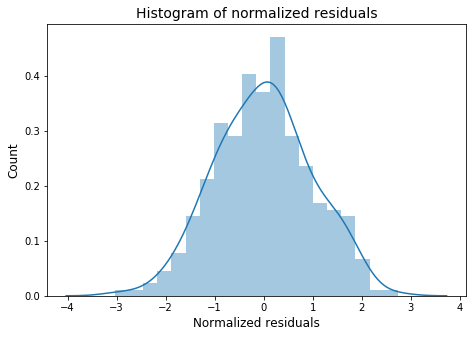

In [16]:
# Histogram of normalized residuals 
plt.figure(figsize=(7.5,5))
sns.distplot(res_sm.resid_pearson, bins=20)
plt.title('Histogram of normalized residuals', fontsize=14)
plt.xlabel('Normalized residuals', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

#### Q-Q plot of residuals

<Figure size 540x360 with 0 Axes>

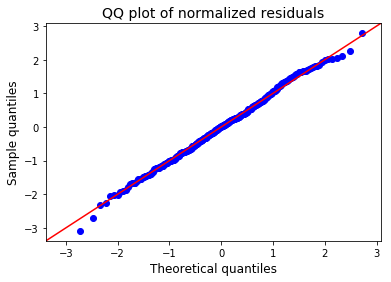

In [17]:
plt.figure(figsize=(7.5,5))
fig = qqplot(res_sm.resid_pearson, line='45', fit='True')
plt.title('QQ plot of normalized residuals', fontsize=14)
plt.xlabel('Theoretical quantiles', fontsize=12)
plt.ylabel('Sample quantiles', fontsize=12)
plt.show()

#### Normality (Shapiro-Wilk) test of the residuals

In [18]:
_,p = shapiro(res_sm.resid)

print('The Shapiro-Wilk p-value = '+str(round(p, 3)))

The Shapiro-Wilk p-value = 0.874


#### Normality Takeaways
* The first two plots show a relatively normal distributions where as p value of the Shapiro-Wilk test does not.
* Just as was the case with the summary normality information, there is contrasting information.

___
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">7.</span>
            Looking at the outliers with Cook's distance. 
        </td>
    </tr>
</table>

#### Cook's distance
The larger the Cook's distance, the more that value distorts the linear regression. These value should be considered as possible outliers. The actual value for what is the cutoff to examine depends on number if observations in the dataset. For this data the threshold could be 4/obs or 4/(obs-features-1). ~0.013

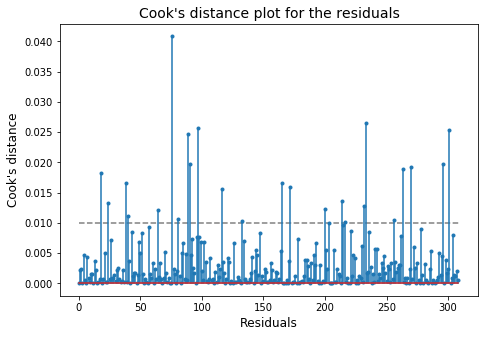

In [19]:
inf = influence(res_sm)

(c, p) = inf.cooks_distance
plt.figure(figsize=(7.5,5))
plt.stem(np.arange(len(c)), c, markerfmt='.')
plt.hlines(y=0.01, xmin= 0, xmax= len(c), color='grey', linestyle='--')
plt.title("Cook's distance plot for the residuals", fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel("Cook's distance", fontsize=12)
plt.show()

In [20]:
# for the result, and more in a dataframe
inf.summary_frame().head()

,dfb_y-int,dfb_age,dfb_sex,dfb_bmi,dfb_bp,dfb_s1,dfb_s2,dfb_s3,dfb_s4,dfb_s5,dfb_s6,cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
315,-0.011848,-0.004593,0.004576,0.001319,0.013700,0.000506,-0.004730,0.001515,0.011999,-0.004082,-0.005246,0.000073,-0.028253,-0.028298,0.018333,-0.207073,-0.206740
71,0.042065,-0.037006,-0.065639,-0.026867,0.113336,-0.008889,0.024073,-0.018533,-0.049041,0.010514,0.035259,0.002177,0.154595,0.154733,0.048561,0.684907,0.684296
23,-0.023834,-0.012579,-0.020255,-0.015129,0.027880,-0.119531,0.133958,0.086921,-0.001550,0.094953,-0.050771,0.002407,-0.162486,-0.162720,0.155939,-0.378574,-0.378029
10,0.003289,-0.004980,-0.002818,-0.005335,0.004622,0.001790,-0.001377,-0.004579,-0.004619,-0.001512,0.002068,0.000013,0.012000,0.012020,0.055048,0.049803,0.049719
336,0.041705,-0.013247,-0.069067,0.050597,-0.063286,0.014121,-0.034512,0.035420,0.133920,-0.025028,0.013365,0.004738,0.228204,0.228305,0.065934,0.859311,0.858933


#### Outliers Takeaway
* There are a number of values that would need to be looked at as possible outliers based on the Cook's distance.
* When removing outliers, careful consideration needs to be taken that it is not introducing bias, or skewing the results. 
* For now, this is not the main priority. 

<br>
<br>

![separator2](https://user-images.githubusercontent.com/7065401/39119518-59fa51ce-46ec-11e8-8503-5f8136558f2b.png)

### Part 2: StatsModel OLS with less features.
In this sections, the information regarding the p-values of coef and the multicollinearity will be used to simplify the model. Only the coef with statistically significant p-values will be used as features to train the model. Those features are `y-int`, `sex`, `bmi`, `bp`, and `s5`. Besides the significant coef, you can also consider the multicollinearity of the values as well, which would leave `y-int`, `age`, `sex`, `bmi`, `bp`, and `s6`. Leaving overlapping feature: `y-int`, `sex`, `bmi`, and`bp`. `s5` has a value that is in between the two limits people tend to use for cut off of multicollinearity, so for now we are going to keep it in the model. 

In general simpler models can be less prone to overfitting, but also can be prone to underfitting. Additionally, different features might introduce bias. All of these factors and more need to be considered when choosing features for training the model. 

There are two different ways to code StatsModels to use only certain features. You can (1) manipulate the X dataset so that it only has the features that you want to use to train the model (like it is the case in sklearn). __Or__ you can (2) use the formula attribute to tell it which columns to use. The second case is really convenient because you do not need to manipulate your dataframe, only the formula, which makes looking at how different features effect a model, quick and easy. One caveat of the formula is that your data all needs to be in one dataframe, therefor I will the first way since the dataframe is already split into X and Y. Below is a example of the code that would be used for formula method (2).
```
# Making a new dataframe with X and Y.
XY_train_sm = pd.concat([X_train_sm, Y_train], axis=1, sort=False)

# Visual check on the dataset
X_train_sm_pv.head()

# The formula used p-value training test
formula_pv = XY_train_sm.columns[-1]+'~ '+XY_train_sm.columns[0]+'+sex+bmi+bp+s5'
formula_pv

# retraining the model with the p-values formula
lr_sm_pv = sm.OLS(formula=formula_pv, data=XY_train_sm)
res_sm_pv = lr_sm_pv.fit()

print(res_sm_pv.summary())
```

---
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">8.</span>
            Retraining and predicting with a simpler StatsModels Linear Regression Model.
        </td>
    </tr>
</table>

In [21]:
# p-value features
features_pv = ['y-int', 'sex', 'bmi', 'bp', 's5']

# Making new X_train_sm, X_test_sm datasets.
X_train_sm_pv = X_train_sm[features_pv].copy()
X_test_sm_pv = X_test_sm[features_pv].copy()

# Vistual check on the dataset
print(X_train_sm_pv.head())
print(X_test_sm_pv.head())

     y-int       sex       bmi        bp        s5
315    1.0 -0.044642 -0.020218 -0.053871 -0.010904
71     1.0 -0.044642  0.033673  0.125158  0.026714
23     1.0  0.050680  0.060618  0.031053  0.133599
10     1.0 -0.044642 -0.083808  0.008101 -0.062913
336    1.0 -0.044642  0.085408 -0.036656  0.080948
     y-int       sex       bmi        bp        s5
140    1.0  0.050680  0.014272  0.042530 -0.033249
217    1.0 -0.044642  0.031517  0.101058  0.033657
439    1.0  0.050680 -0.015906  0.017282 -0.046879
311    1.0 -0.044642  0.040140 -0.057314  0.012553
321    1.0 -0.044642  0.051996  0.079254  0.098646


In [22]:
# retraining the model
lr_sm_pv = sm.OLS(Y_train, X_train_sm_pv)
res_sm_pv = lr_sm_pv.fit()

print(res_sm_pv.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     76.82
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           6.00e-45
Time:                        18:58:56   Log-Likelihood:                -1675.9
No. Observations:                 309   AIC:                             3362.
Df Residuals:                     304   BIC:                             3380.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y-int        151.2314      3.147     48.053      0.0

In [23]:
# How do the coef compare to orginal sm/sklearn
_df_res_pv = pd.DataFrame(res_sm_pv.params, columns=['sm_pv'])
df_res['sm_pv'] = _df_res_pv
df_res.round(3)

,sklearn,sm,sm_pv
y-int,151.531,151.531,151.231
age,-59.678,-59.678,NaN
sex,-303.298,-303.298,-225.089
bmi,558.369,558.369,628.376
bp,319.486,319.486,281.883
s1,-783.279,-783.279,NaN
s2,316.650,316.650,NaN
s3,222.998,222.998,NaN
s4,352.210,352.210,NaN
s5,770.213,770.213,569.592


In [24]:
df_res.to_csv('Data/df_res.csv')

In [25]:
# How does it do predicting? 
Y_pred_sm_pv = res_sm_pv.predict(X_test_sm_pv)
print(Y_pred_sm_pv.head())
print(Y_test.head())

140    141.842488
217    228.741819
439    107.998048
311    177.497138
321    272.481082
dtype: float64
     target
140   118.0
217   296.0
439   132.0
311   180.0
321   230.0


#### Comparison Takeaways
* adj R^2 is not as strong(res_sm: 0.523), so this model is not as linear.
* Additionally the log-l, AIC, BIC are all about the same in this model (res_sm: -1164, 3351, 3392 respectively). 
* The prob(Omnibus) (res_sm: 0.811) and prob(JB) (res_sm: 0.760) are all smaller which suggest this is a more normal dataset. 

---
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">9.</span>
            Checking the collinearity.
        </td>
    </tr>
</table>

#### Variance influence factors (VIF)

In [26]:
_df_vif_pv = pd.DataFrame(index=X_train_sm_pv.columns)
_df_vif_pv["VIF PV Factor"] = [vif(X_train_sm_pv.values, i) for i in range(X_train_sm_pv.shape[1])]
df_vif["VIF PV Factor"] = _df_vif_pv
round(df_vif, 1)

,VIF Factor,VIF PV Factor
y-int,1.0,1.0
age,1.3,NaN
sex,1.3,1.1
bmi,1.6,1.3
bp,1.5,1.4
s1,53.6,NaN
s2,36.6,NaN
s3,14.5,NaN
s4,8.9,NaN
s5,9.8,1.4


#### Variable Independence Takeaways (non-collinearity)
* None of the features so collinearity, not even `s5`.
* With just the VIF factor, which feature is correlated with which other features is lost. VIF should be used with the heat map to see if only a subset of features cause higher correlation in a group of features. 

---
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">10.</span>
            Looking at the residual of the fitted target values.
        </td>
    </tr>
</table>

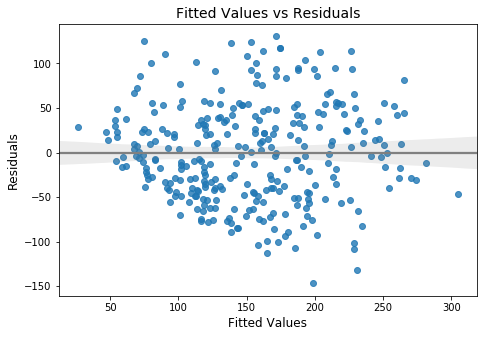

In [27]:
plt.figure(figsize=(7.5,5))
sns.regplot(x=res_sm_pv.fittedvalues, y=res_sm_pv.resid, line_kws={'color':'grey'})
plt.title("Fitted Values vs Residuals", fontsize=14)
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.show()

#### Fitted Residual Takeaways
* This looks relatively similar to the first model graph for negative residuals. 
* Positive residuals are more homoscedastic.

---
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">11.</span>
            Looking at the normality of the data by looking at the normalized residuals, the Q-Q plot, and the Shapiro-Wilk test. 
        </td>
    </tr>
</table>

#### Histogram of normalized residuals

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


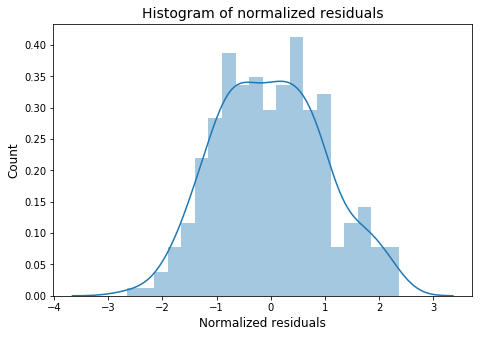

In [28]:
plt.figure(figsize=(7.5,5))
sns.distplot(res_sm_pv.resid_pearson, bins=20)
plt.title('Histogram of normalized residuals', fontsize=14)
plt.xlabel('Normalized residuals', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

#### Q-Q plot of residuals

<Figure size 540x360 with 0 Axes>

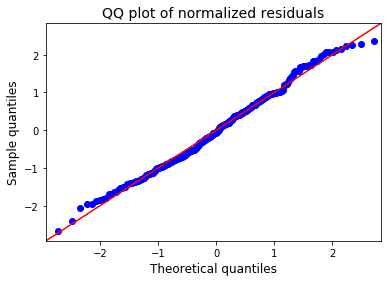

In [29]:
plt.figure(figsize=(7.5,5))
fig = qqplot(res_sm_pv.resid_pearson, line='45', fit='True')
plt.title('QQ plot of normalized residuals', fontsize=14)
plt.xlabel('Theoretical quantiles', fontsize=12)
plt.ylabel('Sample quantiles', fontsize=12)
plt.show()

#### Normality (Shapiro-Wilk) test of the residuals

In [30]:
_,p_2 = shapiro(res_sm_pv.resid)

print('The Shapiro-Wilk p-value = '+str(round(p_2, 3)))

The Shapiro-Wilk p-value = 0.058


#### Normality Takeaways
* The Histogram of normalized residuals does not look as normalized as the first model. 
* The Q-Q plot still show a relatively normal distributions 
* The p value of the Shapiro-Wilk test is much better, but still high.
* Still not the most normalized dataset

___
<table style="width: 100%; border: 4px solid #00F;">
    <tr>
        <td width="80"><img src="https://user-images.githubusercontent.com/7065401/39122907-870d233a-46f6-11e8-84b1-ede5e3714362.png"></td>
        <td style="font-size: 14px; text-align: left">
            <span style="color: #00F; font-size: 20px; font-weight: 900; margin-right: 5px;">12.</span>
            Looking at the outliers with Cook's distance. 
        </td>
    </tr>
</table>

#### Cook's distance
The larger the Cook's distance, the more that value distorts the linear regression. These value should be considered as possible outliers. The actual value for what is the cutoff to examine depends on number if observations in the dataset. For this data the threshold could be 4/obs or 4/(obs-features-1). Still ~0.013

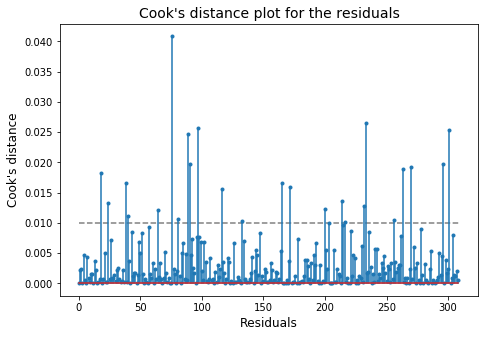

In [31]:
inf_pv = influence(res_sm_pv)

(c, p) = inf.cooks_distance
plt.figure(figsize=(7.5,5))
plt.stem(np.arange(len(c)), c, markerfmt='.')
plt.hlines(y=0.01, xmin= 0, xmax= len(c), color='grey', linestyle='--')
plt.title("Cook's distance plot for the residuals", fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel("Cook's distance", fontsize=12)
plt.show()

In [32]:
# for the result, and more in a dataframe
inf_pv.summary_frame().head()

,dfb_y-int,dfb_sex,dfb_bmi,dfb_bp,dfb_s5,cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
315,-0.030876,0.020518,0.004058,0.027203,-0.009274,0.000542,-0.052005,-0.052065,0.008940,-0.548180,-0.547548
71,0.040558,-0.069117,-0.009025,0.116895,-0.014685,0.003564,0.133366,0.133484,0.036799,0.682916,0.682316
23,-0.017800,-0.014597,-0.002932,0.013271,-0.046581,0.000684,-0.058375,-0.058461,0.031090,-0.326360,-0.325880
10,0.028761,-0.027618,-0.043342,0.036909,-0.022531,0.001016,0.071169,0.071260,0.022080,0.474238,0.473632
336,0.053942,-0.046902,0.089570,-0.097156,0.090208,0.006468,0.179843,0.179834,0.030428,1.015135,1.015186


#### Outliers Takeaway
* There are more values that would need to be looked at as possible outliers based on the Cook's distance.

<br>

#### General Takeaways
* There are some positive and negative trade off to decreasing the features used to train the model.
* But no clear winning model from this.

<br>
<br>

![separator2](https://user-images.githubusercontent.com/7065401/39119518-59fa51ce-46ec-11e8-8503-5f8136558f2b.png)

### Part 3: sklearn output mimic

This is just to show how to access similar attributes that are shown in the `Diabetes OLS Analysis - sklearn.ipynb` notebook.

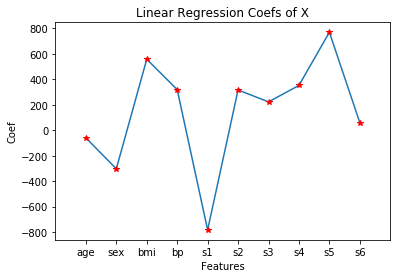

In [33]:
# Looking at the plot of the sm coefs, 
# which are the same as sklearn.
plt.title('Linear Regression Coefs of StatsModels X')

plt.title('Linear Regression Coefs of X')
plt.xlabel('Features')
plt.ylabel('Coef')
plt.xlim(-1, len(df[load_diabetes().feature_names].columns))
plt.xticks(range(len(df[load_diabetes().feature_names].columns)), df[load_diabetes().feature_names].columns)
_ = plt.plot(res_sm.params[1:], '-', res_sm.params[1:], 'r*')

In [34]:
# Predicting. Need to also add const to X_test.
# Should be the same as sklearn
X_test_sm = sm.add_constant(X_test)
Y_pred_sm = res_sm.predict(X_test_sm)
Y_pred_sm.head()

140    143.401343
217    216.836423
439    110.523776
311    166.308534
321    294.649319
dtype: float64

In [35]:
pred_sm = res_sm.get_prediction(X_test_sm)
pred_sm.summary_frame().head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
140,143.401343,8.120836,127.419890,159.382796,36.340625,250.462061
217,216.836423,10.056185,197.046287,236.626558,109.141298,324.531548
439,110.523776,7.729823,95.311821,125.735732,3.575218,217.472334
311,166.308534,11.617462,143.445875,189.171193,58.006679,274.610388
321,294.649319,16.734588,261.716378,327.582261,183.783774,405.514865


In [36]:
# How to check for MAE in sm.
print('Mean Absolute Error (MAE): {}'.format(np.mean(sm.tools.eval_measures.meanabs(Y_test, Y_pred_sm.values)).round(2)))

# not sure how to do the R-sq in this case
print('Adj Variance score (R^2): {}'.format(res_sm.rsquared_adj.round(4)))

Mean Absolute Error (MAE): 76.07
Adj Variance score (R^2): 0.5232


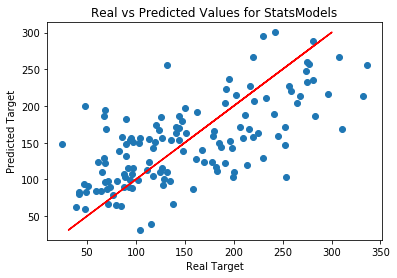

In [37]:
# Making a Scatter Plot

plt.title('Real vs Predicted Values for StatsModels')
plt.xlabel('Real Target')
plt.ylabel('Predicted Target')

plt.scatter(Y_test, Y_pred_sm)
plt.plot(Y_pred_sm, Y_pred_sm, color='red')